**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask** (credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting) - **this notebook**
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) 
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis) 
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E)  - **based on this notebook**
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs)
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------


This notebook is sort of a companion piece to the one about time series for finance: https://www.kaggle.com/konradb/ts-3-time-series-for-finance - similarly to volatility clustering, intermittent time series is a problem usually (but not exclusively) encountered in business applications. When predicting sales or demand in retail, we have three main issues to deal with: data is (frequently) integer-valued, intermittent and not that large. We will discuss those different aspects in the following sections:

* [Croston model](#section-one)
* [ML approach](#section-two)
* [New launches](#section-three)

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

We will be using the data from the M5 competition: https://www.kaggle.com/c/m5-forecasting-accuracy. The contest used a hierarchical sales data from Walmart to forecast daily sales for the next 28 days. From the comp description page: "*The data covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events*". 


We start by formatting the data to a more usable format.

In [4]:
xdat = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [6]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')


In [7]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [8]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


That looks more manageable - let's get started.


<a id="section-one"></a>
# Croston model

## Basic Croston

A first simple approach to predicting intermittent demand series is the Croston model, which takes a three step approach:
- evaluate the average demand level when there is a demand occurrence
- evaluate the average time between two demand occurrences
- forecast the demand as the demand level (when there is an occurrence) multiplied by the probability of having an occurrence.

We go about this by adjusting exponential smoothing to our problem. If we denote the actual demand level by $X_t$ and our level estimate as $a_t$, then if $X_t > 0$ we get:

\begin{equation}
a_{t+1} = \alpha X_t + (1- \alpha) a_t 
\end{equation}

and $a_{t+1} = a_t$ otherwise; $\alpha$ has the same role as in the basic exponential smoothing (see https://www.kaggle.com/konradb/ts-1a-smoothing-methods for a refresher). 

A second important component of a model for an intermittent time series is periodicity: we capture time between two demand occurrences $p$ and time elapsed time elapsed since the previous demand occurrence $q$. As before, for $X_t > 0$ we can specify

\begin{equation}
p_{t+1} = \alpha q + (1-\alpha) p_t
\end{equation}

and $p_{t+1} = p_t$ otherwise. The forecast for a given period is the given by

\begin{equation}
f_{t+1} = \frac{a_t}{p_t}
\end{equation}


How does it perform in practice? Let's begin by subsetting our dataset to a single product x store combination:

<AxesSubplot:xlabel='date'>

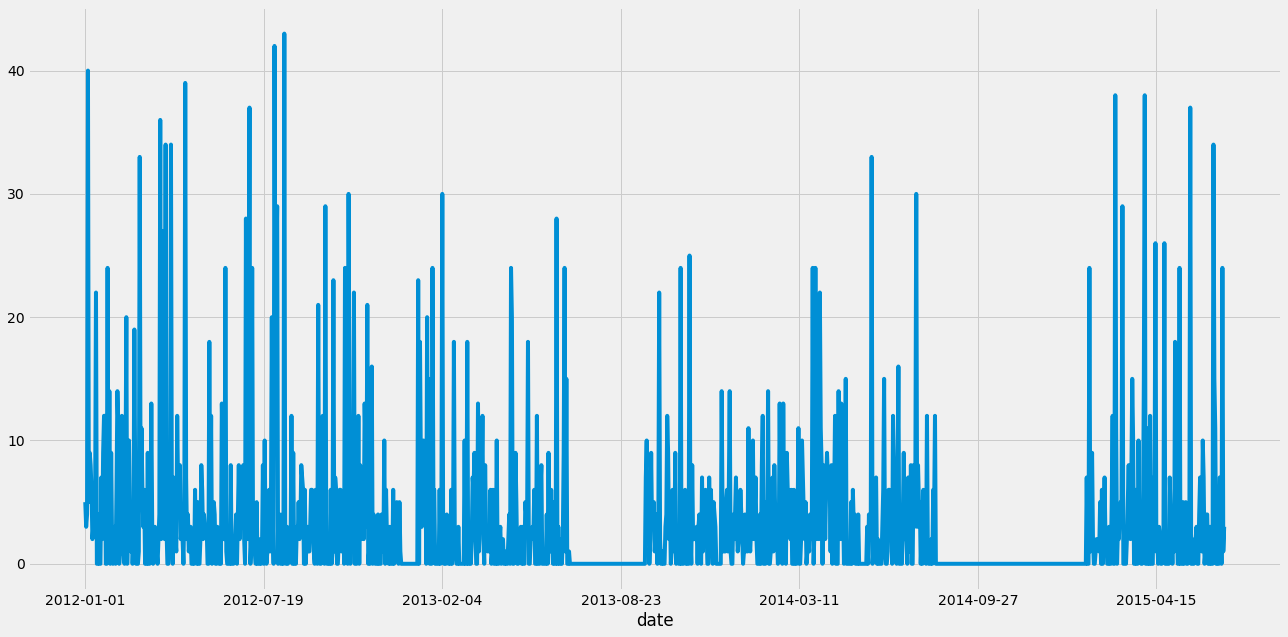

In [9]:
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1') ][['date', 'sales']].copy()
df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]
df.set_index('date').sales.plot()


Dislacimer: the code for both the basic Croston model and the TSB variant (discussed below) is taken from the excellent post by Nicolas Vandeput: https://medium.com/towards-data-science/croston-forecast-model-for-intermittent-demand-360287a17f5f

In [10]:
def Croston(ts,extra_periods=1,alpha=0.4):
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

Generate a forecast with base Croston method:

In [11]:
pred_croston =  Croston(df.sales, extra_periods = 10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [12]:
pred_croston = pred_croston.Forecast.head(len(df))

print('RMSE: ' + str(my_rmse(df.sales,pred_croston)))

RMSE: 6.9581


<AxesSubplot:xlabel='date'>

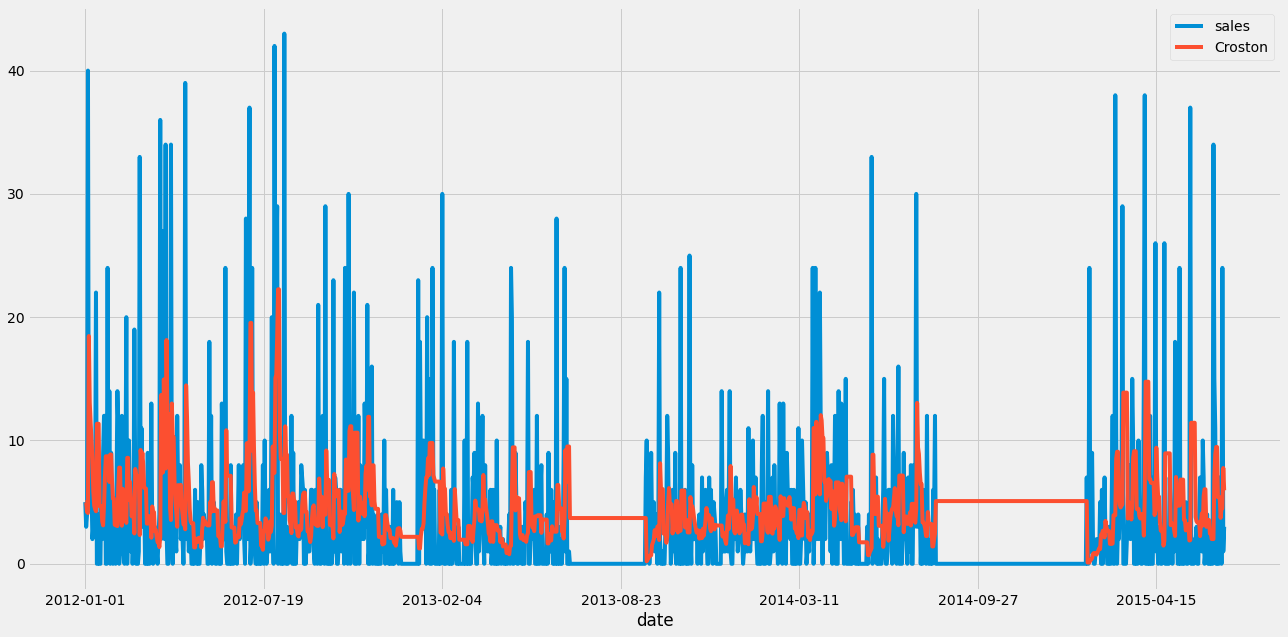

In [13]:
# xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
df['Croston'] = pred_croston.values
df.set_index('date').plot()

If there is a period with no demand, the forecast from the Croston model is not updated - which is counterintuitive:
- extended period with no demand should lead to a reduced forecast going forward
- surge in demand after a long period of inactivity should lead to an increase

In 2011 Teunter, Synteos and Babai proposed an extension to the basic Croston model: https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437. The main change they proposed was allowing the model to decrease the periodicity estimate, even in the absence of demand. 

The level of demand is estimated in the same manner as before

\begin{equation}
a_{t+1} = \alpha X_t + (1- \alpha) a_t 
\end{equation}

We change the definition of periodicity: $p$ denotes the probability of having a demand occurrence and it will be updated each period:
- decrease if there is no demand occurrence, in an exponential manner 
- increase otherwise

\begin{equation}
p_{t+1} = \beta + (1- \beta) p_t
\end{equation}

if $X_t > 0$ and $(1- \beta) p_t$ otherwise. The forecast for a given period is the given by

\begin{equation}
f_{t+1} = a_{t+1}p_{t+1}
\end{equation}

Caveat emptor:
- the forecast f is defined as the periodicity p multiplied by the level a (**and not divided by it, as in the original model**)
- the forecast for t+1 is defined based on the level and periodicity estimates of t+1 (**and not t**)



In [14]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [15]:
pred_croston_tsb =  Croston_TSB(df.sales, extra_periods = 10, alpha = 0.1, beta = 0.1)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE: ' + str(my_rmse(df.sales,pred_croston_tsb)))


RMSE: 6.1255


<AxesSubplot:xlabel='date'>

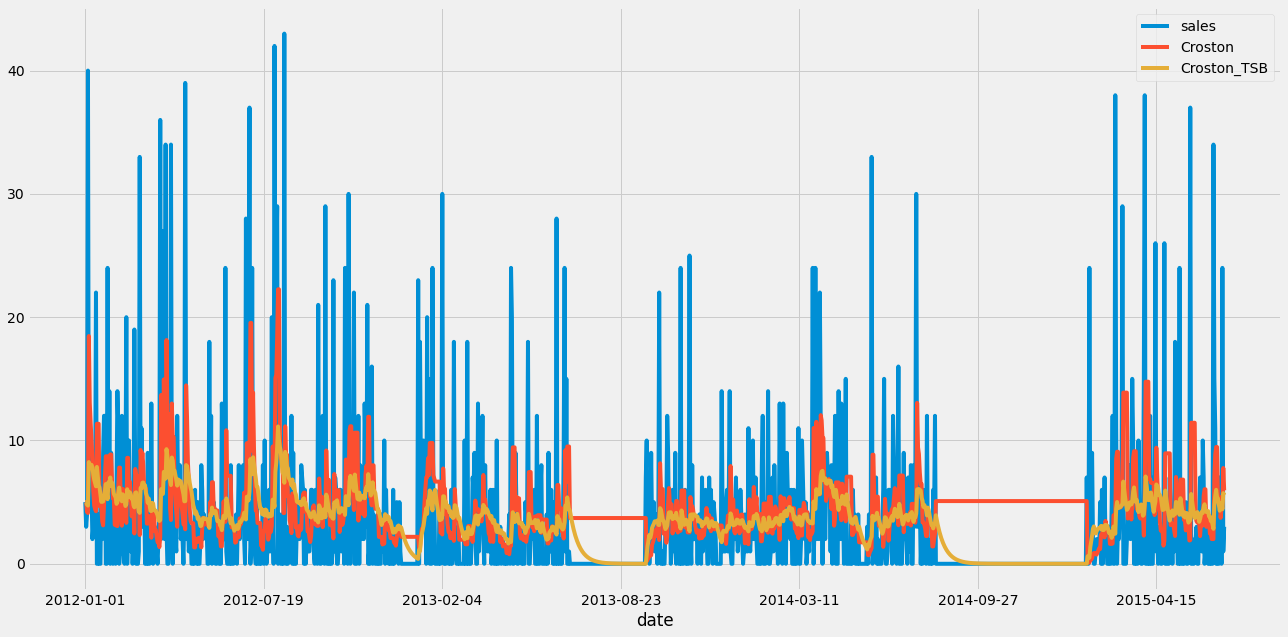

In [16]:
df['Croston_TSB'] = pred_croston_tsb.values
df.set_index('date').plot()

Moving from vanilla to TSB Croston:
- improves the error (somewhat)
- solves the issues with forecast adjustment in zero sales periods

Overall, it gives us a way of handling an intermittent time series, but it does not have a natural extension to a multivariate case - so we need to try something else. 

<a id="section-two"></a>
# ML approach

If you are dealing with tabular data (which is a category time series belong to), tree-based methods are something of a Swiss-Army chainsaw: they work out of the box, with minimal requirements on data. In this section we will formulate a time series problem as a regression one, so that we can use LightGBM to predict the sales in multiple stores (we continue working with the data from the M5 competition). Quick reminder of what our data looks like:

In [17]:
xdat.head(4)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


<AxesSubplot:xlabel='date'>

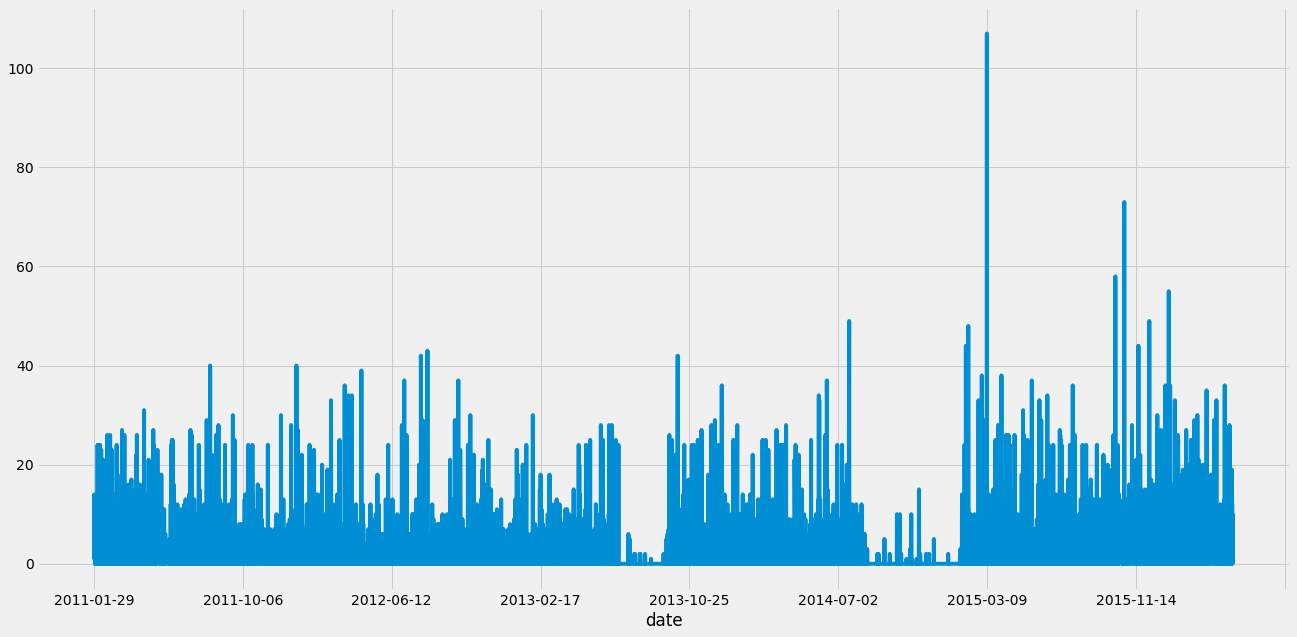

In [18]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

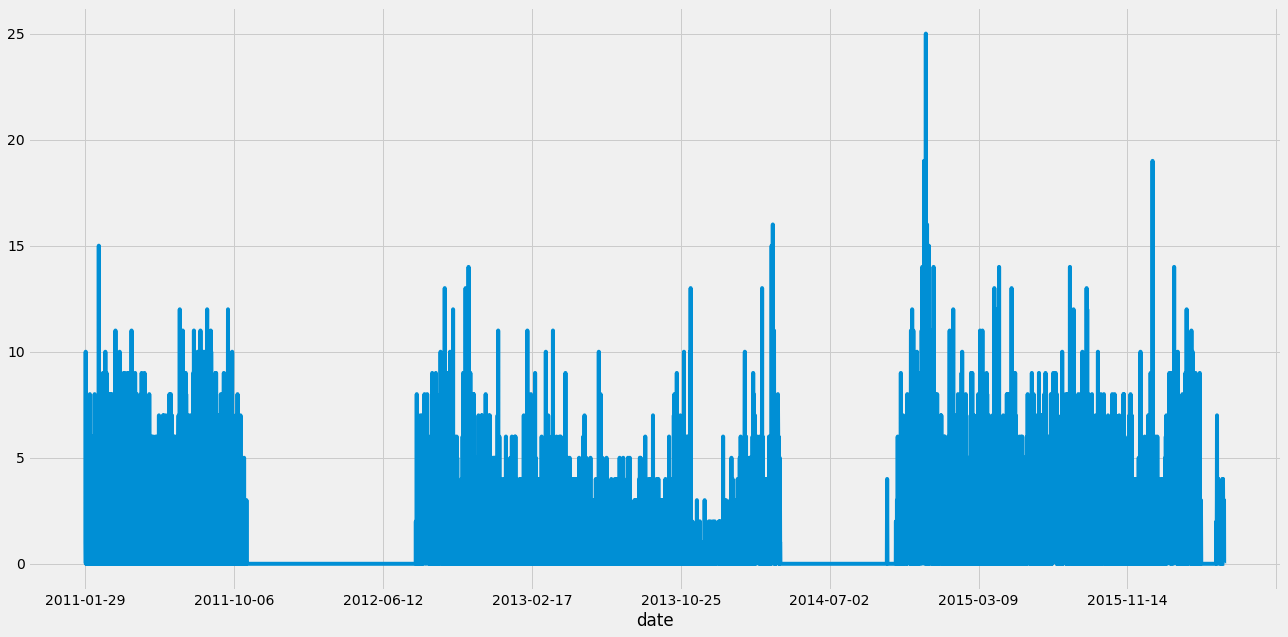

In [19]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<AxesSubplot:xlabel='date'>

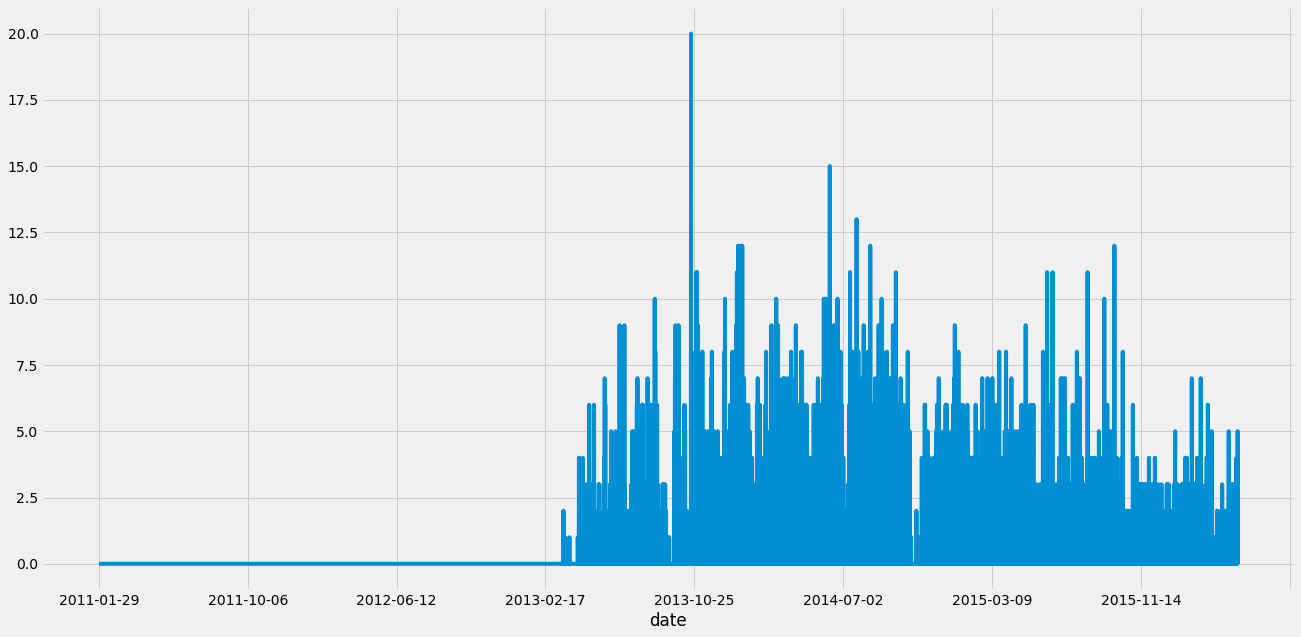

In [20]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

We could run multiple separate models like Croston, but it's infeasible for two reasons:
- there are a LOT of store x product combinations
- shared factors between stores

Instead, we will generate some features to capture the temporal dynamics and treat the problem of predicting all the series jointly as a regression.

In [21]:
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


Start with lag features: 
- simple moving averages over a given period
- shifted 

In [22]:
def create_features(dt, lags = [28], wins = [7,28]):
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).fillna(-1)

    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)
        
    return dt

xdat = create_features(xdat)

xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0,-1.0,-1.0,-1.0


Time-based features:

In [23]:
xdat['date'] = pd.to_datetime(xdat["date"])

date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }
    
for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in xdat.columns:
        xdat[date_feat_name] = xdat[date_feat_name].astype("int16")
    else:
        xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")

In [24]:
# encode categorical features
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id']
for cc in cat_feats:
    le = LabelEncoder()
    xdat[cc] = le.fit_transform(xdat[cc])
    

In [25]:
# split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = xdat.loc[xdat.date < cutoff].copy()
xvalid = xdat.loc[xdat.date >= cutoff].copy()

del xdat

xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28,week,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,2011-01-29,1,0,-1.0,-1.0,-1.0,4,1,1,2011,29


In [26]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()

xtrain.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)
xvalid.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)


We are finally ready to go down the usual lgbm path:

In [27]:
dtrain = lgb.Dataset(xtrain , label = ytrain,  free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label = yvalid,   free_raw_data=False)

Can we exploit the nature of the data?

<AxesSubplot:ylabel='Density'>

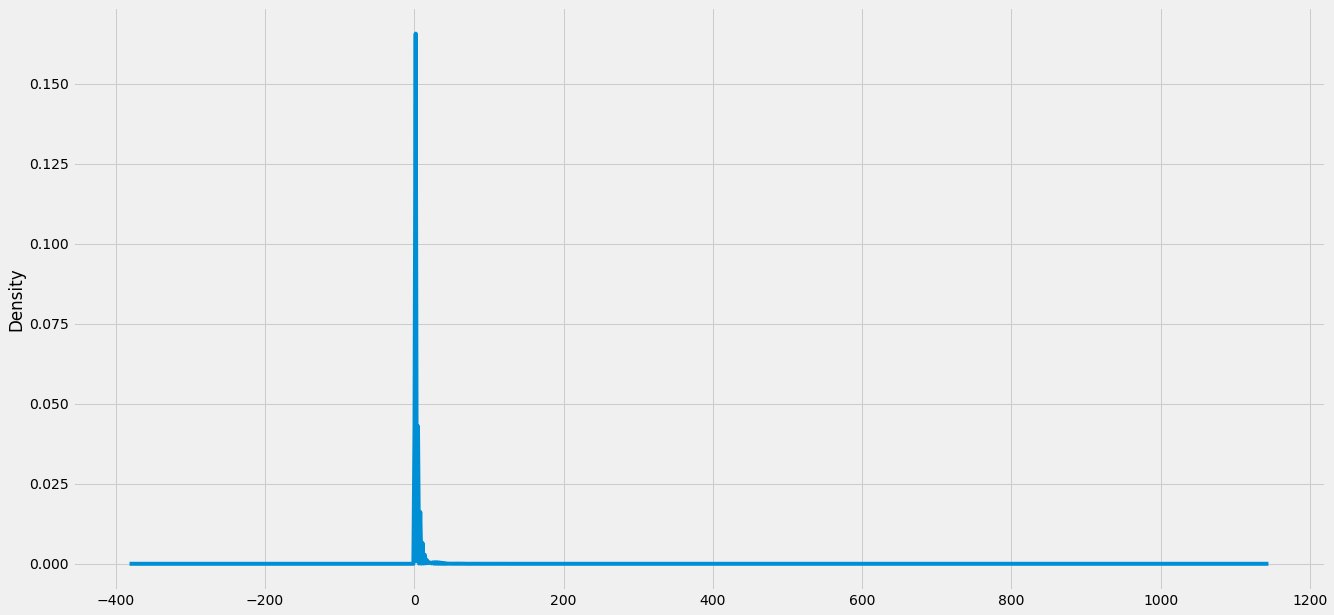

In [28]:
ytrain.plot.density()

Giant spike at zero $\implies$ we need a criterion that allows for a probability mass 

In [29]:

params = {
        "objective" : "poisson",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  early_stopping_rounds = 150,
                  verbose_eval=100)  

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.692646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 11
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.66383	valid_1's rmse: 2.33185
[200]	training's rmse: 2.61925	valid_1's rmse: 2.3214
[300]	training's rmse: 2.57912	valid_1's rmse: 2.31679
[400]	training's rmse: 2.55221	valid_1's rmse: 2.31651
[500]	training's rmse: 2.53173	valid_1's rmse: 2.31832
Early stopping, best iteration is:
[363]	training's rmse: 2.56246	valid_1's rmse: 2.31553


More general step: tweedie https://en.wikipedia.org/wiki/Tweedie_distribution

In [30]:
params = {
        "objective" : "tweedie",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  early_stopping_rounds = 150,
                  verbose_eval=100) 


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.689199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 22977264, number of used features: 11
[LightGBM] [Info] Start training from score 0.203045
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.67983	valid_1's rmse: 2.30314
[200]	training's rmse: 2.6414	valid_1's rmse: 2.29437
[300]	training's rmse: 2.61341	valid_1's rmse: 2.29108
[400]	training's rmse: 2.5914	valid_1's rmse: 2.29104
Early stopping, best iteration is:
[289]	training's rmse: 2.61873	valid_1's rmse: 2.29018


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

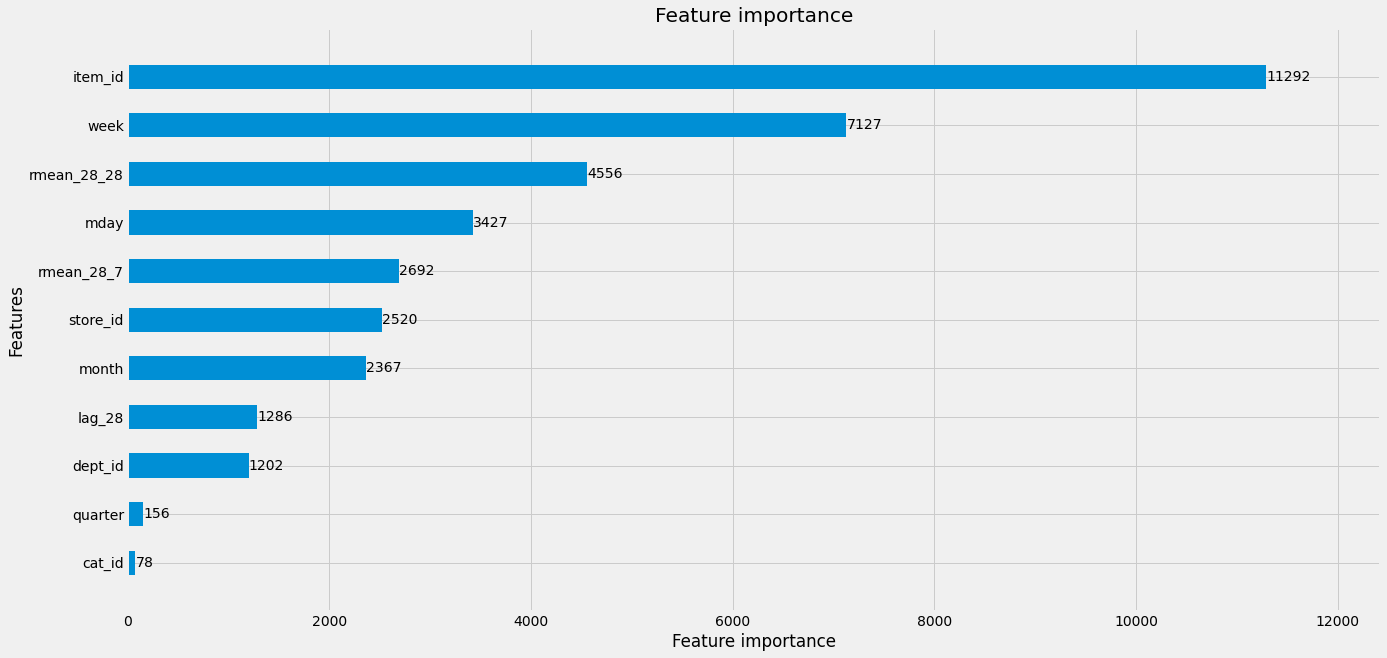

In [31]:
lgb.plot_importance(m_lgb,height = 0.5)

Takeaway:
- time series as regression
- (lagged) rolling statistics
- distribution of target
- careful about ranges $\rightarrow$ extrapolation


<a id="section-three"></a>
# New launches

Finally, we will have a quick look at the problem of predicting the sales patterns for new products which - by their very nature - do not have a lot of history to use for a time series model. We will use a subset of the Visuelle dataset: https://github.com/HumaticsLAB/GTM-Transformer. We have training / validation split prepared by the dataset authors:


In [32]:
xtrain = pd.read_csv('../input/partial-visuelle/train.csv')
xtrain.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.004695,0.073239,0.061972,0.066667,0.046009,0.043192,0.026291,0.019718,0.012207,0.014085,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,0.005634,0.109859,0.128638,0.135211,0.082629,0.098592,0.063850,0.052582,0.034742,0.138967,...,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,0.002817,0.207512,0.177465,0.095775,0.041315,0.030047,0.015023,0.006573,0.010329,0.005634,...,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem


In [33]:
xtest = pd.read_csv('../input/partial-visuelle/test.csv')
xtest.head(3)

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.032864,0.062911,0.054460,0.056338,0.042254,0.033803,0.037559,0.029108,0.016901,0.012207,...,short sleeves,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05081.png,grey,georgette,hem
1,0.046948,0.060094,0.083568,0.117371,0.079812,0.089202,0.078873,0.061033,0.023474,0.015962,...,culottes,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05082.png,red,bengaline,strapless
2,0.043192,0.086385,0.079812,0.080751,0.061972,0.062911,0.054460,0.045070,0.021596,0.015962,...,kimono dress,2019-04-17,0.333333,0.307692,0.333333,1.0,PE19/05083.png,white,frise,hem


In [34]:
xtrain.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       'external_code', 'season', 'category', 'release_date', 'day', 'week',
       'month', 'year', 'image_path', 'color', 'fabric', 'extra'],
      dtype='object')

## MultiOutput

Initial idea: predict the entire sequence (sales in the first 12 days) based on the other information.

In [35]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

In [36]:
# transforms categoricals
xdat = pd.concat([x0,x1], axis = 0)
xdat = pd.get_dummies(xdat)
x0 = xdat.iloc[:x0.shape[0]]
x1 = xdat.iloc[x0.shape[0]:]
del xdat

In [37]:
# fit the model
base_model = Ridge()
mo_base = MultiOutputRegressor(base_model, n_jobs=-1)

mo_base.fit(x0, y0)

mo_prediction = mo_base.predict(x1) 

In [38]:
print('(sort of) MSE: ' + str(np.round( np.sqrt(np.average((mo_prediction - y1)**2)) ,4  )))

(sort of) MSE: 0.0508


Let's have a look at a few examples:

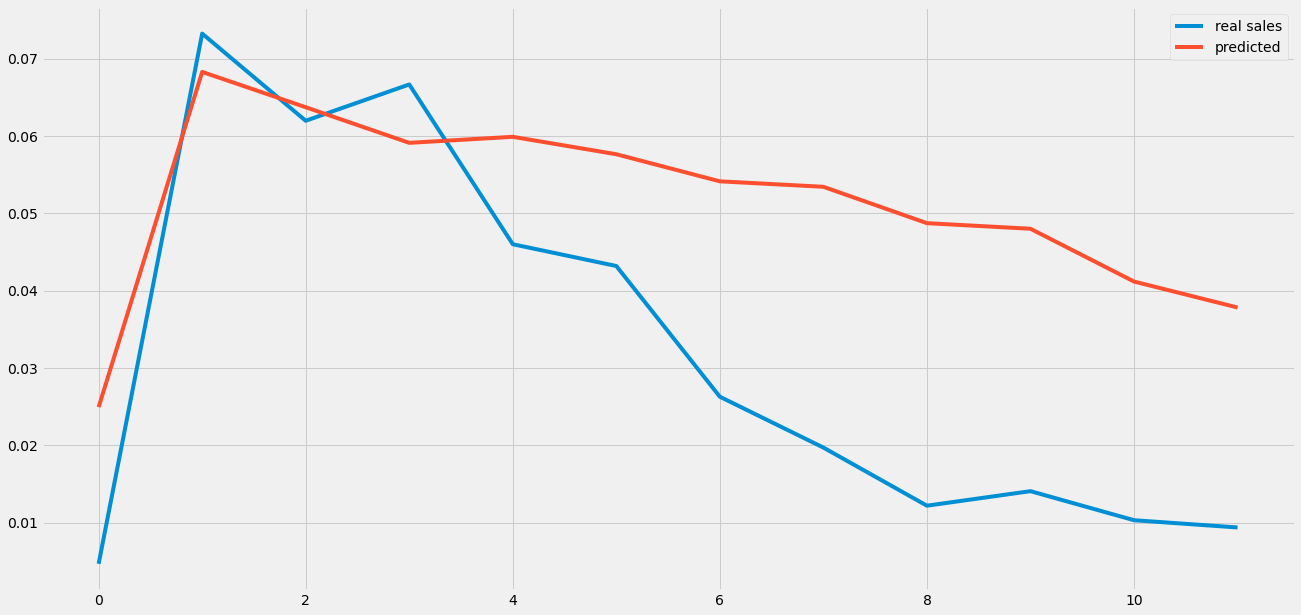

In [39]:
ii = 0 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

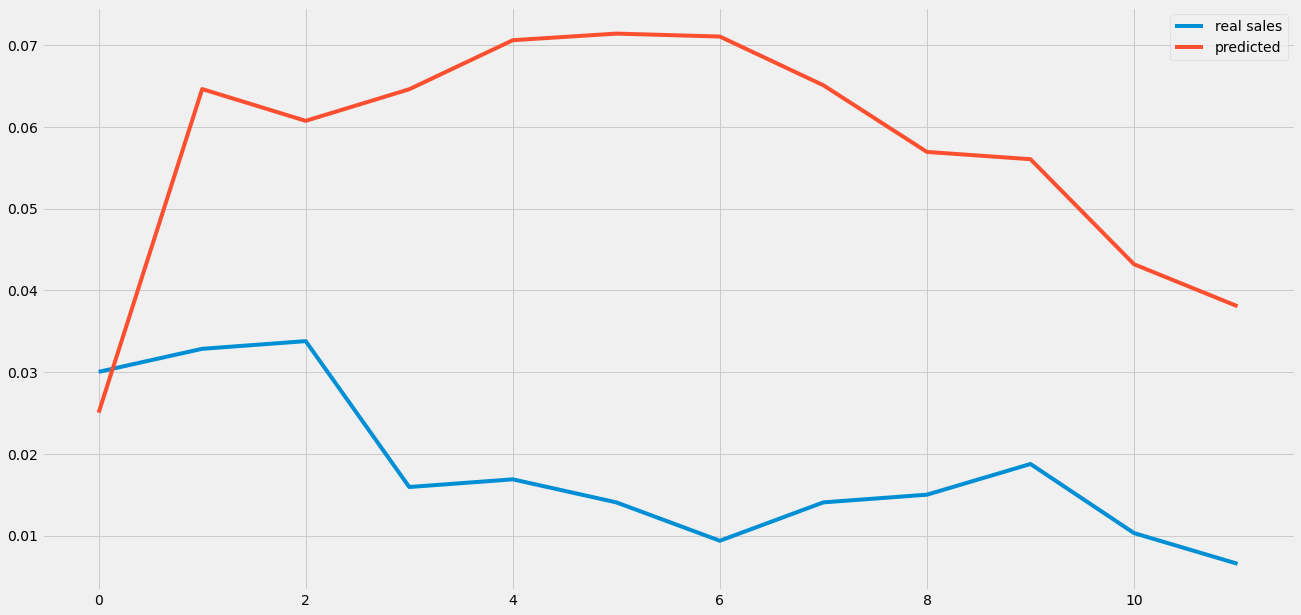

In [40]:
ii = 12
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

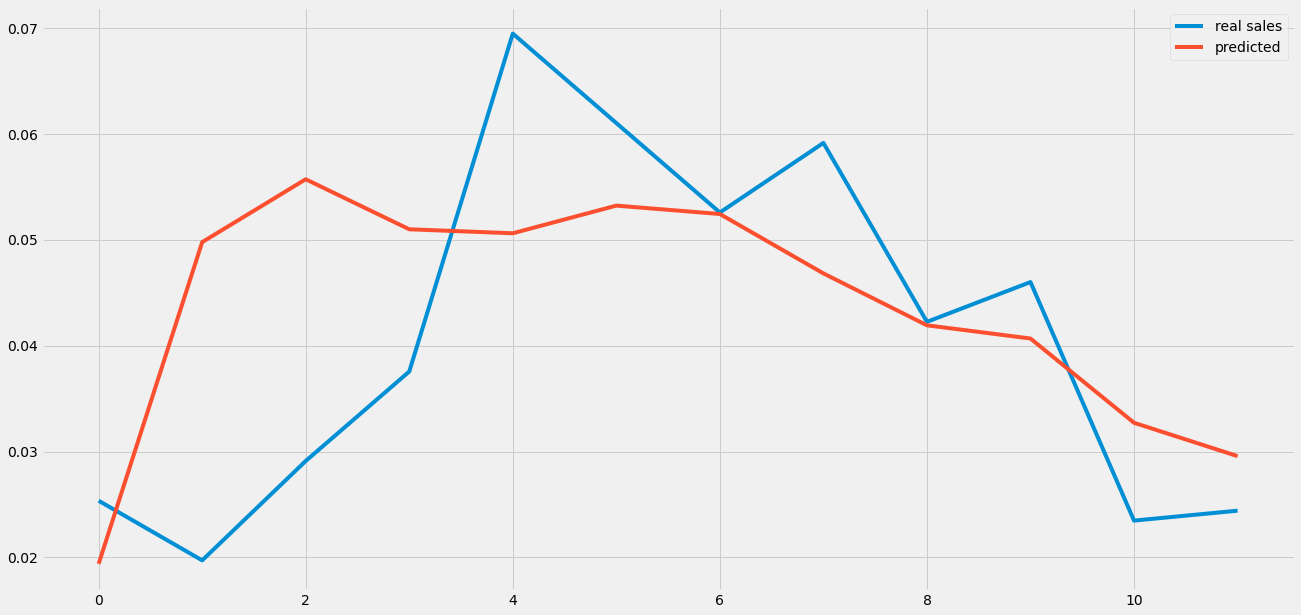

In [41]:
ii = 80
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

What else can we try?


## Embeddings



Alternative approach:
- create embeddings for the categorical part with cat2vec https://openreview.net/pdf?id=HyNxRZ9xg
- cluster the products for which we know the sales
- calculate average target per cluster
- map the new ones to the nearest cluster

In [42]:
def correct_time(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['week'] = df.release_date.dt.isocalendar().week
    df['month'] = df.release_date.dt.month
    df['day'] = df.release_date.dt.day
    
correct_time(xtrain)
correct_time(xtest)

In [43]:
# split into targets and variables we will use for clustering
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

Implementation from https://www.kaggle.com/code/classtag/cat2vec-powerful-feature-for-categorical


### Cat2vec

In [44]:
def apply_w2v(sentences, model, num_features):
    def _average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary: 
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    
    vocab = set(model.wv.index_to_key)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    return np.array(feats)

def gen_cat2vec_sentences(data):
    X_w2v = copy.deepcopy(data)
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c,g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    return X_w2v

def fit_cat2vec_model(data):
    X_w2v = gen_cat2vec_sentences(data)
    for i in X_w2v:
        shuffle(i)
    model = Word2Vec(X_w2v, vector_size= 10, window= 3)
    return model

In [45]:
# fit a cat2vec
c2v_model = fit_cat2vec_model(pd.concat([x0,x1], axis = 0))

In [46]:
# generate the embeddings
x0_c2v = apply_w2v(gen_cat2vec_sentences(x0), c2v_model, 10)
x1_c2v = apply_w2v(gen_cat2vec_sentences(x1), c2v_model, 10)

### Clustering

In [47]:
# fit kmeans
clustering = KMeans(n_clusters = 10)
clustering.fit(x0_c2v)

y0_clusters = clustering.predict(x0_c2v)

In [48]:
# assign the clusters for the test set
y1_clusters = clustering.predict(x1_c2v)

### Mapping

In [49]:

cl_prediction = np.zeros(y1.shape)

for ii in range(10):
    cl_prediction[y1_clusters == ii,:] = y0.loc[y0_clusters == ii].mean()


In [50]:
print('(sort of) MSE: ' + str(np.round( np.sqrt(np.average((cl_prediction - y1)**2)) ,4  )))

(sort of) MSE: 0.0508


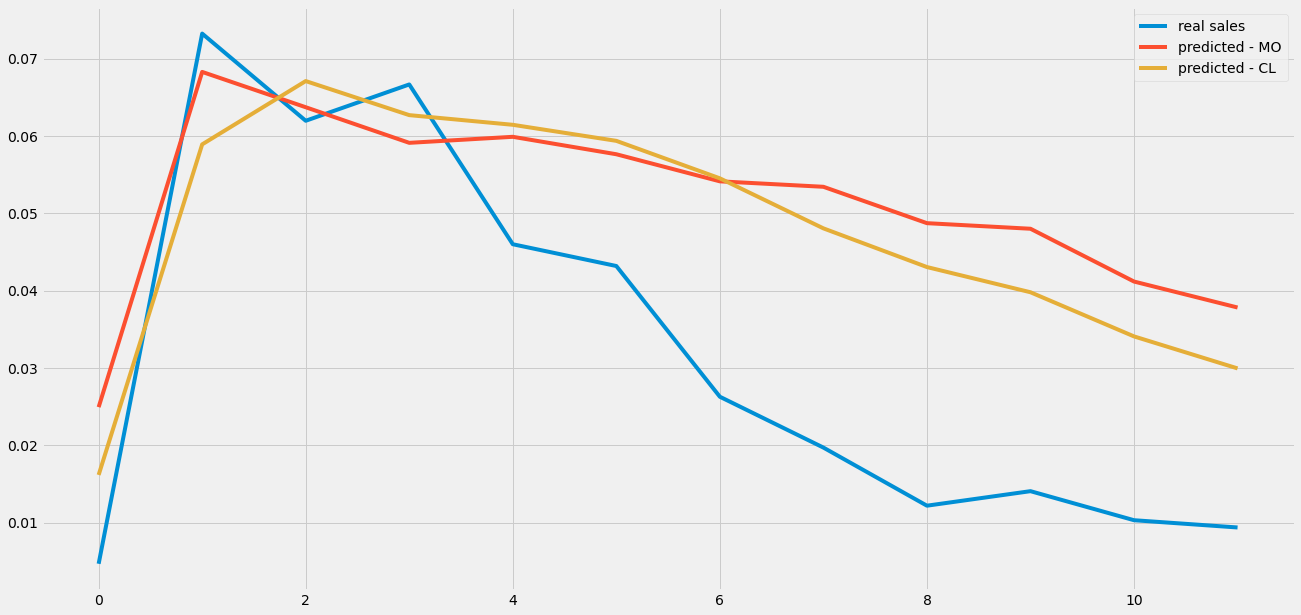

In [51]:
ii = 0 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()

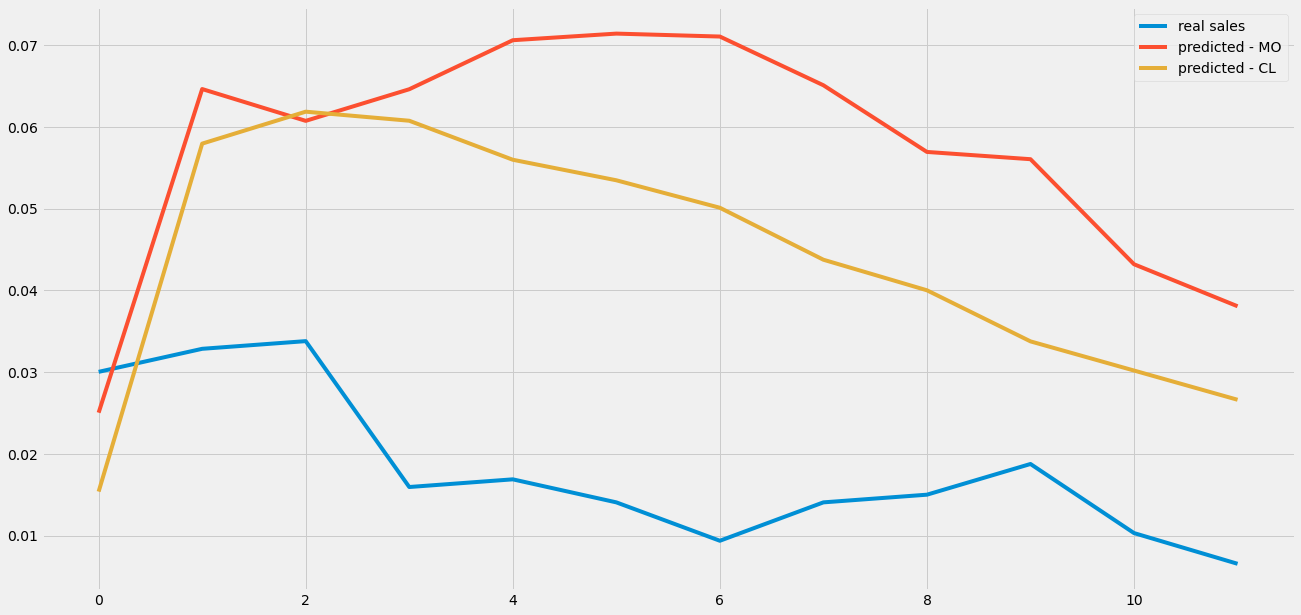

In [52]:
ii = 12 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()

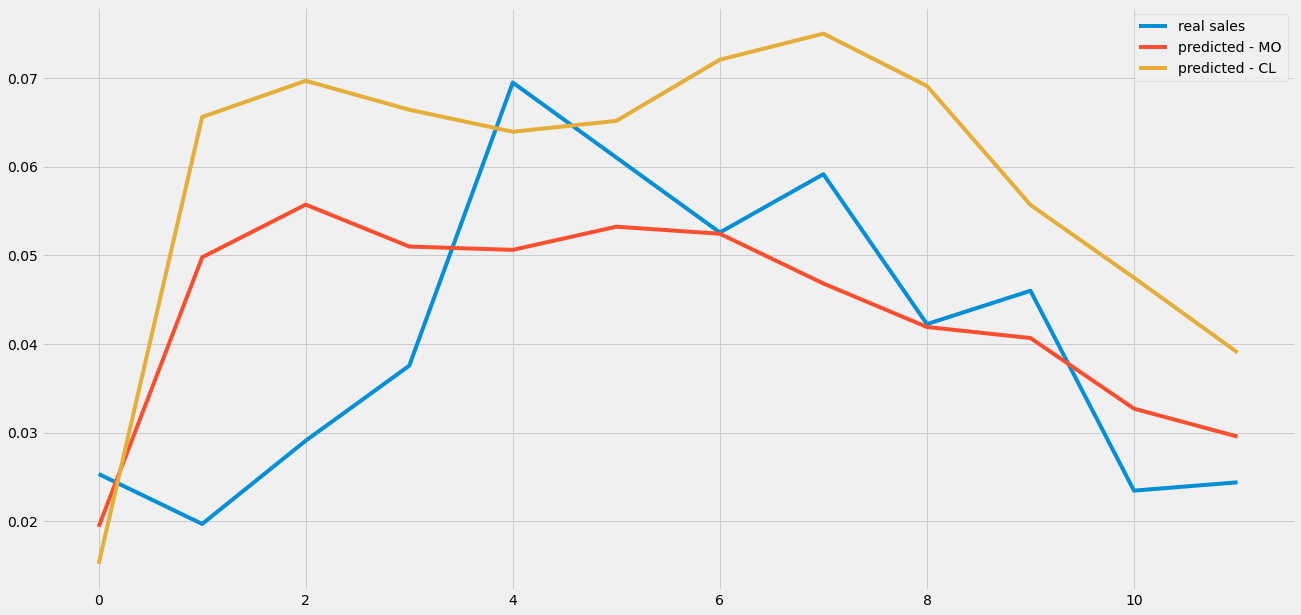

In [53]:
ii = 80
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted - MO")
plt.plot(cl_prediction[ii,:], label = "predicted - CL")
plt.legend()
plt.show()

This concludes our adventure in demand prediction territory:
- Croston model gets you through univariate cases
- LGBM is the way to go for handling multiple series at once
- hybrid approach to predicting new products


Stay tuned! 